# Brain Tumor Segmentation using UNet

## Imports

In [6]:
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

plt.style.use("dark_background")

## Read Data

In [7]:
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

Within path '/kaggle/input/lgg-mri-segmentation/kaggle_3m/' there are folders of structure:
`TCGA_CS_patientId_sliceNumber/TCGA_CS_patientId_sliceNumber_num.tif` **---> for image**
`TCGA_CS_patientId_sliceNumber/TCGA_CS_patientId_sliceNumber_num_mask.tif` **---> for mask**

To get all images and mask we will use glob. Glob is used for pattern matching and directory searching.

Eg: `file1.txt`, `file2.txt`, `file3.csv`, `data.txt`, `data.csv`

`txt_files = glob.glob("*.txt")` will get you all .txt files i.e. `file1.txt` `file2.txt` `data.txt`

We will store image path and mask path in a dataframe

In [10]:
df = pd.DataFrame()
df["mask_file"] = glob.glob(DATA_PATH+"*/*_mask.tif")
df["img_file"] = [path.replace("_mask","") for path in df["mask_file"]]

In [13]:
df["patient_id"] = [path.split("/")[-2] for path in df["mask_file"]]

In [11]:
def get_label(path):
    """Check if there is any mask on mask image or not to get label(tumor or not)"""
    mask = Image.open(path)
    mask = np.asarray(mask)

    return int(mask.max() > 0) # if there is no mask, it will be all black i.e. 0 else if any pixel is white=1, returns True/1

In [12]:
df["tumor_diagnosis"] = df["mask_file"].apply(get_label)

In [14]:
df

,mask_file,img_file,tumor_diagnosis,patient_id
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,TCGA_DU_7010_19860307
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,TCGA_DU_7010_19860307
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1,TCGA_DU_7010_19860307
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1,TCGA_DU_7010_19860307
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1,TCGA_DU_7010_19860307
...,...,...,...,...
3924,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,TCGA_DU_7306_19930512
3925,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,TCGA_DU_7306_19930512
3926,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,TCGA_DU_7306_19930512
3927,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,TCGA_DU_7306_19930512


In [16]:
df.iloc[0,0],df.iloc[0,1], df.iloc[0,2], df.iloc[0,3] 

('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif',
 0,
 'TCGA_DU_7010_19860307')

In [22]:
df = df[['patient_id', 'img_file', 'mask_file', 'tumor_diagnosis']]
df.head()

,patient_id,img_file,mask_file,tumor_diagnosis
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1


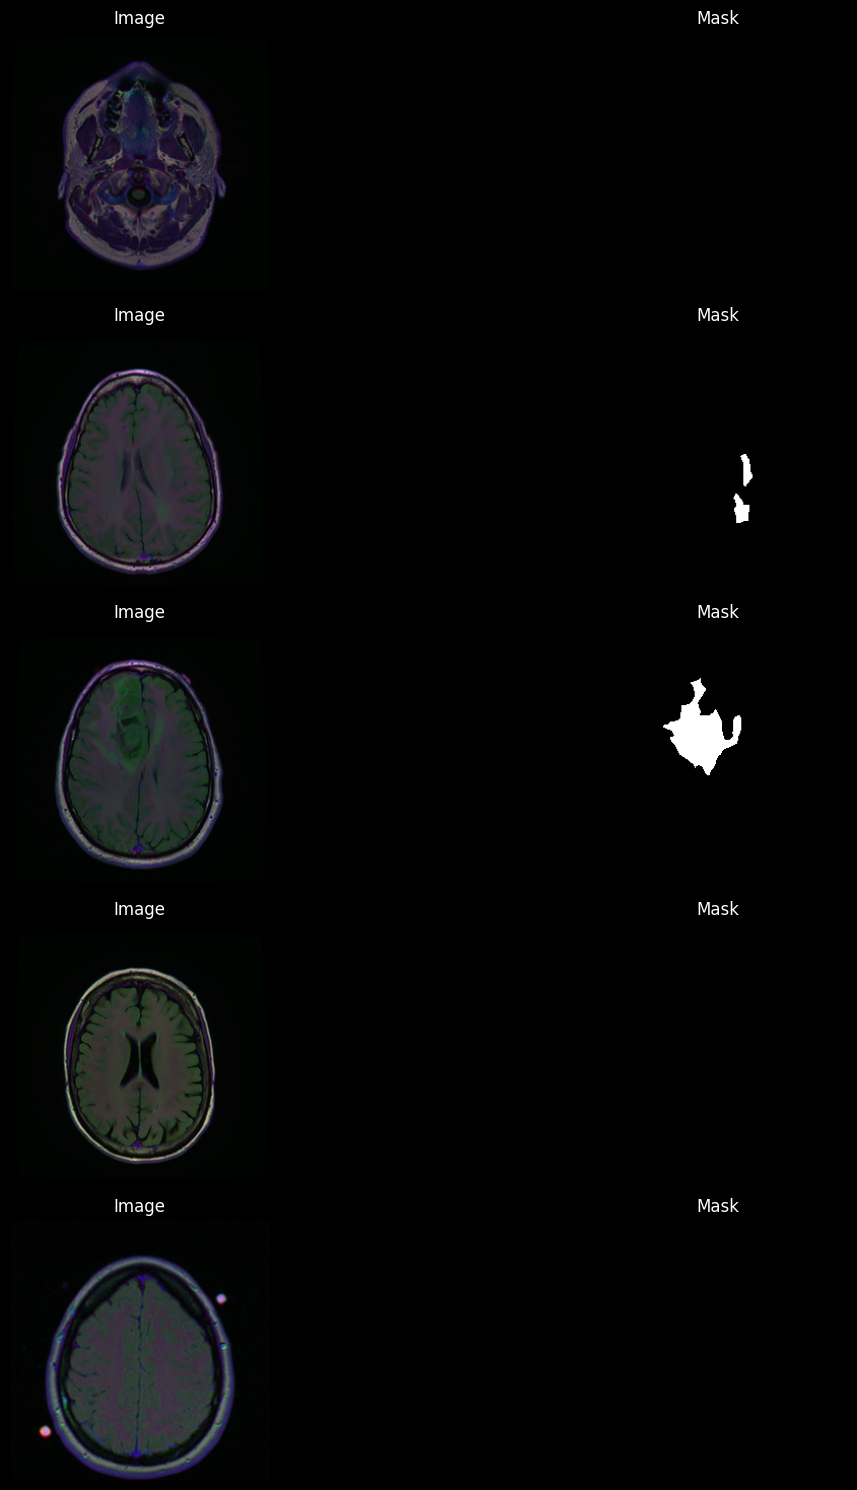

In [25]:
def plot_samples():
    """Function to visualize samples of MRI images and corresponding masks"""
    idx = np.random.randint(0, len(df), (5))
    plt.figure(figsize=(15, 15))

    for i in range(5):
        row = df.iloc[idx[i]]
        plt.subplot(5, 2, i*2+1)
        img = Image.open(row["img_file"])
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(5, 2, i*2+2)
        mask = Image.open(row["mask_file"])
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_samples()

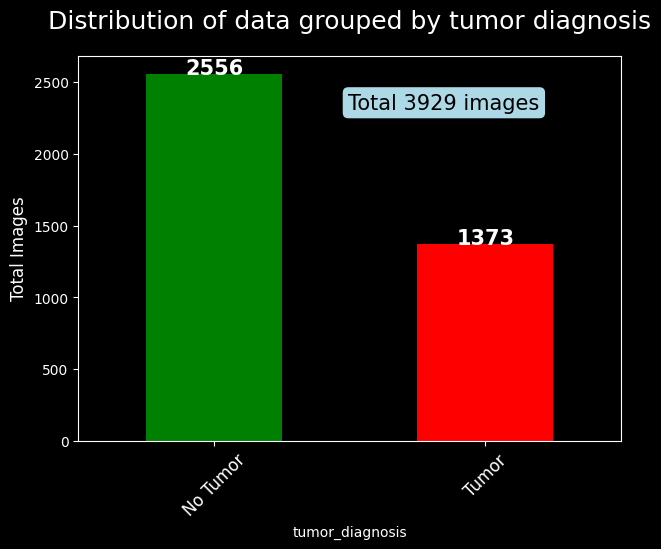

In [36]:
# Data for the bar graph
diagnosis_counts = df['tumor_diagnosis'].value_counts()

# Plot
fig = diagnosis_counts.plot(kind='bar', stacked=True, figsize=(7, 5), color=["green", "red"])

# Customizing the plot
fig.set_xticklabels(["No Tumor", "Tumor"], rotation=45, fontsize=12)
fig.set_ylabel('Total Images', fontsize=12)
fig.set_title("Distribution of data grouped by tumor diagnosis", fontsize=18, y=1.05)

# Annotate each bar with its value
for i, count in enumerate(diagnosis_counts.values):
    fig.annotate(int(count), xy=(i, count - 30), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")

# Add text for total number of images
fig.text(1.2, max(diagnosis_counts) - 200, f"Total {len(df)} images", size=15,
        color="black",
        ha="right", va="center",
        bbox=dict(boxstyle="round",
                  fc=("lightblue"),
                  ec=("black"),
                  )
        )

plt.show()
